In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith('langchain_study_2024')

LangSmith 추적을 시작합니다.
[프로젝트명]
langchain_study_2024


`MemorySaver` checkpointer

In [3]:
from langgraph.checkpoint.memory import MemorySaver

# 메모리 저장소 생성
memory = MemorySaver()

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [5]:
########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]

In [6]:
########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
tool = TavilySearch(max_results=3)
tools = [tool]

In [7]:
llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [8]:
# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)

In [9]:
########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [10]:
# 상태 그래프 생성
graph_builder = StateGraph(State)

In [11]:
# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

In [12]:
# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=[tool])

In [13]:
# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

In [14]:
# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

In [16]:
########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

In [17]:
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

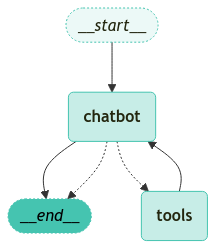

In [18]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [19]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,         
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

In [20]:
# 첫 질문
question = (
    "내 이름은 `이인환` 입니다. 학생들에게 코딩을 가르칩니다. 만나서 반가워요"
)

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 이인환님! 만나서 반갑습니다. 코딩을 가르치시는 일은 정말 멋진 일입니다. 학생들에게 어떤 언어를 주로 가르치시나요? 또는 특별히 가르치고 싶은 주제가 있으신가요?


In [21]:
# 이어지는 질문
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신의 이름은 이인환입니다.


In [22]:
# 이어지는 질문
question = "소놀코딩 유튜브에 대해서 검색해주세요"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_iCDjy1YHjxeXcSX19hKk2Htj)
 Call ID: call_iCDjy1YHjxeXcSX19hKk2Htj
  Args:
    query: 소놀코딩 유튜브
================================= Tool Message =================================
Name: tavily_web_search

["<document><title>소놀코딩 유튜브 채널로 코딩 배워보세요 : 네이버 블로그</title><url>https://m.blog.naver.com/nasu0210/222428706773</url><content>소놀코딩 유튜브 채널로 코딩 배워보세요 : 네이버 블로그 소놀코딩 유튜브 채널로 코딩 배워보세요 소놀코딩과 함께 하시는 많은 분들이 코딩 학습을 통해 문제해결력과 창의력을 키워 4차 산업혁명시대의 필수 인재로 성장할 수 있도록 돕고자 합니다. 소놀코딩 유튜브 채널에는 다양한 강의가 있습니다. 파이썬 강의입니다. 파이썬 왕기초, 기초, 중급 강의가 있습니다. C언어 강의입니다. 아두이노 강의입니다. 앱인벤터 강의입니다. 여러가지 메이커 프로젝트를 진행하면 코딩에 더욱 재미를 느낄 수 있습니다. 매주 금요일 7시에는 파이썬 왕기초 문제 풀이 강의를 업로드 하고 있습니다. 소프트웨어놀이터(코딩&메이커) : 네이버 카페코딩콘텐츠,SW,스크래치,앱인벤터2,아두이노,C언어, C#, 파이썬,IoT,사물인터넷, 클라우드, 빅데이터,웹 cafe.naver.com 소놀코딩_Sonol Coding소놀코딩은 코딩을 연구하고 공부하며 그 내용을 많은 분들과 나누고자 하는 채널입니다. 소놀코딩과 함께 하시는 많은 분들이 코딩 학습을 통해 문제해결력과 창의력을 키워 4차 산업혁명시대(인공지능, 사물인터넷, 빅

In [23]:
# 이어지는 질문
question = "방금 내가 뭐라고 물었지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================

당신은 "소놀코딩 유튜브에 대해서 검색해주세요"라고 물으셨습니다.


In [26]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='내 이름은 `이인환` 입니다. 학생들에게 코딩을 가르칩니다. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='e188f712-21fb-41fb-bf56-bb71186666b4'),
 AIMessage(content='안녕하세요, 이인환님! 만나서 반갑습니다. 코딩을 가르치시는 일은 정말 멋진 일입니다. 학생들에게 어떤 언어를 주로 가르치시나요? 또는 특별히 가르치고 싶은 주제가 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 117, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f2cd28694a', 'finish_reason': 'stop', 'logprobs': None}, id='run-cbd97a11-bf47-496d-a8f3-953c50fc9e31-0', usage_metadata={'input_tokens': 117, 'output_tokens': 61, 'total_tokens': 178, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(co

In [27]:
# 설정된 config 정보
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efcf251-b938-6b4d-800c-e8bcaf92ddd2'}}

In [28]:
# 저장된 값(values)
snapshot.values

{'messages': [HumanMessage(content='내 이름은 `이인환` 입니다. 학생들에게 코딩을 가르칩니다. 만나서 반가워요', additional_kwargs={}, response_metadata={}, id='e188f712-21fb-41fb-bf56-bb71186666b4'),
  AIMessage(content='안녕하세요, 이인환님! 만나서 반갑습니다. 코딩을 가르치시는 일은 정말 멋진 일입니다. 학생들에게 어떤 언어를 주로 가르치시나요? 또는 특별히 가르치고 싶은 주제가 있으신가요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 117, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f2cd28694a', 'finish_reason': 'stop', 'logprobs': None}, id='run-cbd97a11-bf47-496d-a8f3-953c50fc9e31-0', usage_metadata={'input_tokens': 117, 'output_tokens': 61, 'total_tokens': 178, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  

In [29]:
snapshot.metadata["writes"]["chatbot"]["messages"][0]

AIMessage(content='당신은 "소놀코딩 유튜브에 대해서 검색해주세요"라고 물으셨습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 7433, 'total_tokens': 7456, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f2cd28694a', 'finish_reason': 'stop', 'logprobs': None}, id='run-72183168-eda5-4ba9-a4b7-c8485ed7dd70-0', usage_metadata={'input_tokens': 7433, 'output_tokens': 23, 'total_tokens': 7456, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [30]:
from langchain_teddynote.messages import display_message_tree

# 메타데이터(tree 형태로 출력)
display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "당신은 "소놀코딩 유튜브에 대해서 검색해주세요"라고 물으셨습니다."
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage:
                            completion_tokens: 23
                            prompt_tokens: 7433
                            total_tokens: 7456
                            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
                            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
                        model_name: "gpt-4o-mini-2024-07-18"
                        system_fingerprint: "fp_f2cd28694a"
                        finish_reason: "stop"
                        logprobs: None
                    type: "ai"
                    name: None
                    id: "run-721831